Dataset loaded: 768 samples, 8 features (Pima Indians Diabetes)
Train set: 614 samples
Test set: 154 samples
Simulated missing data: 30.0% missing values (MAR + MCAR)

Generating 5 diverse imputed datasets using MICE...
  Imputation 1/5 complete
  Imputation 2/5 complete
  Imputation 3/5 complete
  Imputation 4/5 complete
  Imputation 5/5 complete

Generated 5 diverse imputed datasets.
Baseline Model: Simple Mean Imputation
Baseline AUC: 0.8226
MICE AUC (Aggregated): 0.8419

Performance Improvement:
  Absolute: +0.0193
  Relative: +2.34%


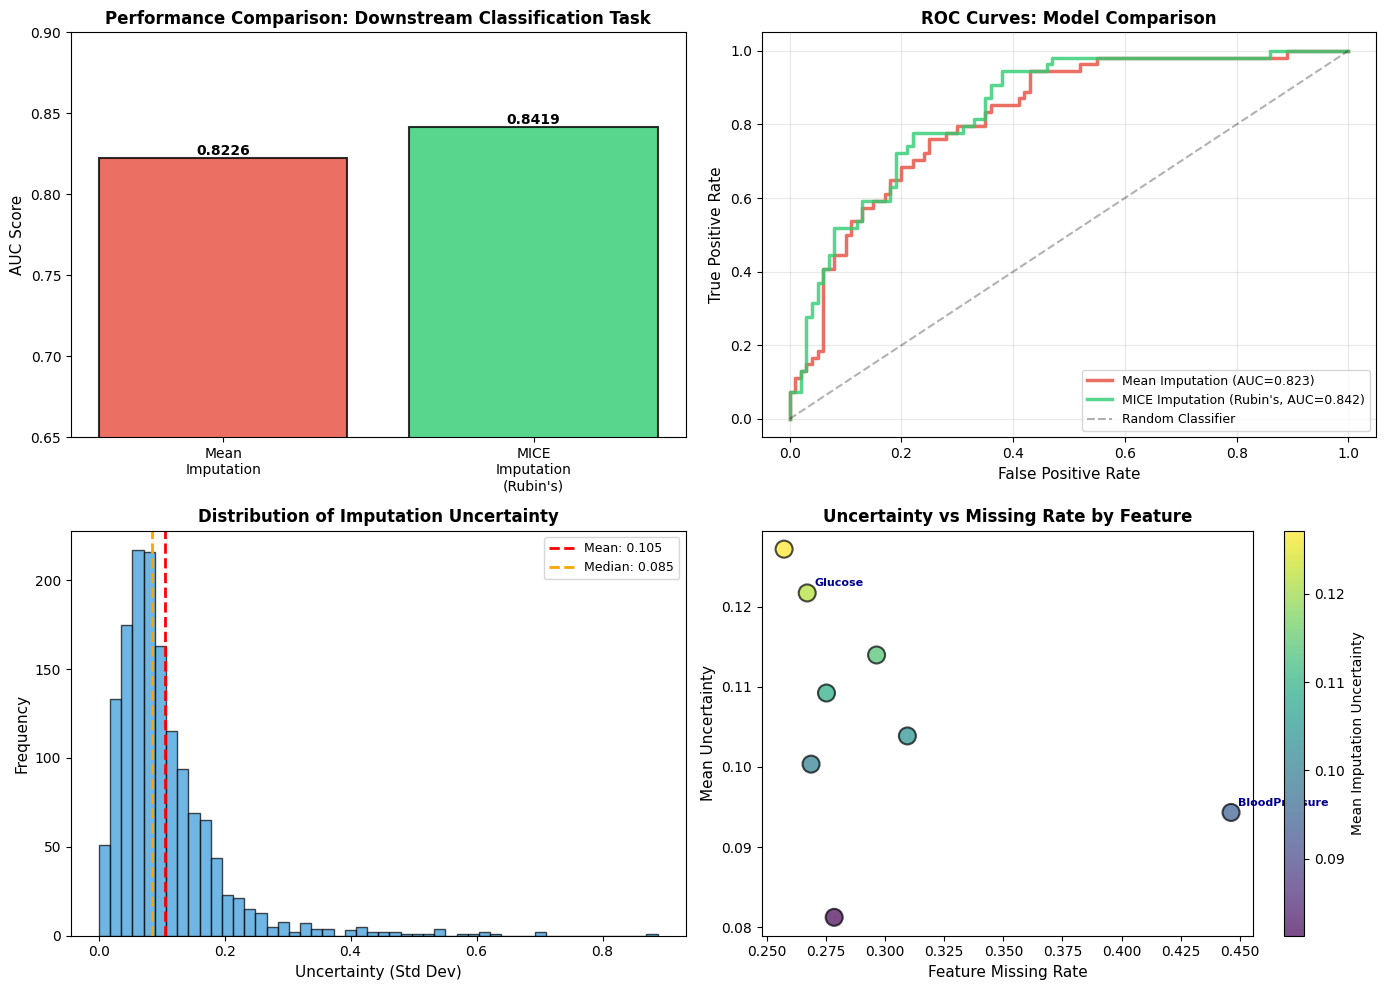


Visualization saved: impute_pro_results.png

Final dataset saved: final_imputed_data_with_uncertainty.csv
  Shape: (614, 24)
  Columns: 24 (values, flags, uncertainties)
Complete!


In [9]:
"""AI-Driven Uncertainty-Quantified Imputation for Biomedical Data.

This module implements a sophisticated imputation pipeline using Multiple Imputation
by Chained Equations (MICE) with proper uncertainty quantification via Rubin's Rules.
Designed for handling missing data in clinical datasets with complex missingness patterns.

Demo with Pima Indians Diabetes dataset.

Author: Daniel Nguyen
"""

import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from xgboost import XGBClassifier

warnings.filterwarnings('ignore')

# Reproducibility
np.random.seed(42)


class DataLoader:
    """Handles loading and preprocessing of biomedical datasets."""

    def __init__(self, dataset_url: str):
        self.dataset_url = dataset_url
        self.data = None
        self.feature_names = None

    def load_pima_diabetes(self) -> tuple:
        """Load and preprocess Pima Indians Diabetes dataset.

        Returns:
            Tuple of (X_scaled, y, feature_names)
        """
        self.data = pd.read_csv(self.dataset_url, header=None)
        self.data.columns = [
            'Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
            'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'
        ]

        print(f"Dataset loaded: {self.data.shape[0]} samples, "
              f"{self.data.shape[1]-1} features (Pima Indians Diabetes)")

        # Separate features and target
        X = self.data.drop('Outcome', axis=1).values
        y = self.data['Outcome'].values
        self.feature_names = self.data.drop('Outcome', axis=1).columns.tolist()

        # Standardize features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        return X_scaled, y, self.feature_names


class MissingnessSimulator:
    """Simulates realistic missing data patterns in biomedical datasets."""

    def __init__(self, missing_rate: float = 0.30):
        self.missing_rate = missing_rate

    def simulate_mar_mcar(self, X_clean: np.ndarray) -> tuple:
        """Simulate Missing At Random (MAR) and Missing Completely At Random (MCAR) patterns.

        Creates a dependency where missingness in BloodPressure depends on Glucose levels,
        then fills remaining cells with MCAR to reach target missing rate.

        Args:
            X_clean: Clean dataset without missing values

        Returns:
            Tuple of (X_messy, missing_mask)
        """
        X_messy = X_clean.copy()
        missing_mask = np.zeros_like(X_messy, dtype=bool)
        n_rows, n_cols = X_messy.shape

        # Define MAR dependency: BloodPressure missingness depends on Glucose
        GLUCOSE_IDX = 1
        BLOOD_PRESSURE_IDX = 2

        # Identify high-glucose samples (above mean)
        high_glucose = X_messy[:, GLUCOSE_IDX] > X_messy[:, GLUCOSE_IDX].mean()

        # High missingness (50%) for high-glucose samples
        high_missing_idx = np.random.choice(
            np.where(high_glucose)[0],
            size=int(high_glucose.sum() * 0.50),
            replace=False
        )
        X_messy[high_missing_idx, BLOOD_PRESSURE_IDX] = np.nan
        missing_mask[high_missing_idx, BLOOD_PRESSURE_IDX] = True

        # Low missingness (1%) for low-glucose samples
        low_glucose = ~high_glucose
        low_missing_idx = np.random.choice(
            np.where(low_glucose)[0],
            size=int(low_glucose.sum() * 0.01),
            replace=False
        )
        X_messy[low_missing_idx, BLOOD_PRESSURE_IDX] = np.nan
        missing_mask[low_missing_idx, BLOOD_PRESSURE_IDX] = True

        # Fill remaining cells with MCAR to reach target rate
        total_cells_to_miss = int(X_messy.size * self.missing_rate)
        current_missing = missing_mask.sum()
        remaining_to_miss = total_cells_to_miss - current_missing

        if remaining_to_miss > 0:
            non_missing_mask = ~missing_mask
            non_missing_idx = np.where(non_missing_mask)

            random_selection = np.random.choice(
                len(non_missing_idx[0]),
                size=remaining_to_miss,
                replace=False
            )

            mcar_rows = non_missing_idx[0][random_selection]
            mcar_cols = non_missing_idx[1][random_selection]

            X_messy[mcar_rows, mcar_cols] = np.nan
            missing_mask[mcar_rows, mcar_cols] = True

        actual_rate = np.isnan(X_messy).sum() / X_messy.size
        print(f"Simulated missing data: {actual_rate:.1%} missing values (MAR + MCAR)")

        return X_messy, missing_mask


class MICEImputer:
    """Multiple Imputation by Chained Equations with uncertainty quantification."""

    def __init__(self, n_imputations: int = 5):
        self.n_imputations = n_imputations
        self.imputed_datasets = []

    def generate_imputations(self, X_messy: np.ndarray) -> list:
        """Generate multiple imputed datasets using MICE.

        Args:
            X_messy: Dataset with missing values

        Returns:
            List of imputed datasets
        """
        print(f"\nGenerating {self.n_imputations} diverse imputed datasets using MICE...")

        for i in range(self.n_imputations):
            # Use ExtraTreesRegressor for capturing non-linear relationships
            et_estimator = ExtraTreesRegressor(
                n_estimators=10,
                max_depth=5,
                random_state=42 + i
            )

            mice_imputer = IterativeImputer(
                estimator=et_estimator,
                max_iter=20,
                tol=0.001,
                imputation_order='random',
                sample_posterior=False,
                random_state=42 + i
            )

            imputed_X = mice_imputer.fit_transform(X_messy)
            self.imputed_datasets.append(imputed_X)
            print(f"  Imputation {i+1}/{self.n_imputations} complete")

        print(f"\nGenerated {self.n_imputations} diverse imputed datasets.")
        return self.imputed_datasets

    def calculate_uncertainty(self, X_messy: np.ndarray) -> tuple:
        """Calculate imputation uncertainty across multiple imputations.

        Args:
            X_messy: Original dataset with missing values

        Returns:
            Tuple of (X_clean, U_impute) - mean imputations and uncertainties
        """
        imputed_stack = np.stack(self.imputed_datasets, axis=0)

        # Mean across imputations
        X_clean = np.mean(imputed_stack, axis=0)

        # Standard deviation as uncertainty measure
        U_impute = np.std(imputed_stack, axis=0)

        # Zero uncertainty for observed values
        U_impute[~np.isnan(X_messy)] = 0.0

        return X_clean, U_impute


class ModelEvaluator:
    """Evaluates imputation quality via downstream classification tasks."""

    def __init__(self, X_test: np.ndarray, y_test: np.ndarray):
        self.X_test = X_test
        self.y_test = y_test
        self.results = {}

    def evaluate_baseline(self, X_train_messy: np.ndarray, y_train: np.ndarray) -> float:
        """Evaluate simple mean imputation baseline.

        Args:
            X_train_messy: Training data with missing values
            y_train: Training labels

        Returns:
            AUC score
        """

        print("Baseline Model: Simple Mean Imputation")


        mean_imputer = SimpleImputer(strategy='mean')
        X_train_imputed = mean_imputer.fit_transform(X_train_messy)

        model = XGBClassifier(
            n_estimators=200,
            max_depth=5,
            learning_rate=0.03,
            subsample=0.8,
            colsample_bytree=0.8,
            eval_metric='logloss',
            random_state=42
        )
        model.fit(X_train_imputed, y_train)

        y_pred = model.predict_proba(self.X_test)[:, 1]
        auc = roc_auc_score(self.y_test, y_pred)

        self.results['baseline'] = {'auc': auc, 'predictions': y_pred}
        print(f"Baseline AUC: {auc:.4f}")

        return auc

    def evaluate_mice_rubins(self, imputed_datasets: list, y_train: np.ndarray) -> float:
        """Evaluate MICE imputation using Rubin's Rules.

        Trains multiple models on different imputations and aggregates predictions.

        Args:
            imputed_datasets: List of imputed training datasets
            y_train: Training labels

        Returns:
            AUC score
        """


        predictions = []

        for i, X_imputed in enumerate(imputed_datasets):
            model = XGBClassifier(
                n_estimators=200,
                max_depth=5,
                learning_rate=0.03,
                subsample=0.8,
                colsample_bytree=0.8,
                eval_metric='logloss',
                random_state=42 + i * 5
            )
            model.fit(X_imputed, y_train)

            y_pred = model.predict_proba(self.X_test)[:, 1]
            predictions.append(y_pred)

        # Aggregate predictions via averaging
        y_pred_aggregated = np.mean(np.stack(predictions, axis=0), axis=0)
        auc = roc_auc_score(self.y_test, y_pred_aggregated)

        self.results['mice'] = {'auc': auc, 'predictions': y_pred_aggregated}
        print(f"MICE AUC (Aggregated): {auc:.4f}")

        return auc

    def print_improvement_summary(self):
        """Print performance improvement statistics."""
        auc_baseline = self.results['baseline']['auc']
        auc_mice = self.results['mice']['auc']

        abs_improvement = auc_mice - auc_baseline
        rel_improvement = (abs_improvement / auc_baseline) * 100

        print(f"\nPerformance Improvement:")
        print(f"  Absolute: {abs_improvement:+.4f}")
        print(f"  Relative: {rel_improvement:+.2f}%")


class ResultsVisualizer:
    """Generates comprehensive visualization reports."""

    def __init__(self, evaluator: ModelEvaluator, U_train: np.ndarray,
                 missing_mask: np.ndarray, feature_names: list):
        self.evaluator = evaluator
        self.U_train = U_train
        self.missing_mask = missing_mask
        self.feature_names = feature_names

    def generate_report(self, output_path: str = 'impute_pro_results.png'):
        """Generate comprehensive 4-panel visualization report."""
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))

        self._plot_auc_comparison(axes[0, 0])
        self._plot_roc_curves(axes[0, 1])
        self._plot_uncertainty_distribution(axes[1, 0])
        self._plot_uncertainty_vs_missing_rate(axes[1, 1])

        plt.tight_layout()
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        plt.show()

        print(f"\nVisualization saved: {output_path}")

    def _plot_auc_comparison(self, ax):
        """Plot AUC comparison bar chart."""
        auc_baseline = self.evaluator.results['baseline']['auc']
        auc_mice = self.evaluator.results['mice']['auc']

        methods = ['Mean\nImputation', 'MICE\nImputation\n(Rubin\'s)']
        aucs = [auc_baseline, auc_mice]
        colors = ['#e74c3c', '#2ecc71'] if auc_mice > auc_baseline else ['#2ecc71', '#e74c3c']

        bars = ax.bar(methods, aucs, color=colors, alpha=0.8,
                      edgecolor='black', linewidth=1.5)
        ax.set_ylabel('AUC Score', fontsize=11)
        ax.set_title('Performance Comparison: Downstream Classification Task',
                     fontsize=12, fontweight='bold')

        auc_range = max(aucs) - min(aucs)
        ax.set_ylim([min(aucs) - auc_range*2, max(aucs) + auc_range*2])
        if max(aucs) < 0.9:
            ax.set_ylim([0.65, 0.9])

        # Add value labels
        for bar, auc in zip(bars, aucs):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{auc:.4f}', ha='center', va='bottom',
                   fontsize=10, fontweight='bold')

    def _plot_roc_curves(self, ax):
        """Plot ROC curves for model comparison."""
        y_test = self.evaluator.y_test
        y_pred_baseline = self.evaluator.results['baseline']['predictions']
        y_pred_mice = self.evaluator.results['mice']['predictions']
        auc_baseline = self.evaluator.results['baseline']['auc']
        auc_mice = self.evaluator.results['mice']['auc']

        fpr_baseline, tpr_baseline, _ = roc_curve(y_test, y_pred_baseline)
        fpr_mice, tpr_mice, _ = roc_curve(y_test, y_pred_mice)

        ax.plot(fpr_baseline, tpr_baseline,
                label=f'Mean Imputation (AUC={auc_baseline:.3f})',
                color='#e74c3c', linewidth=2.5, alpha=0.8)
        ax.plot(fpr_mice, tpr_mice,
                label=f'MICE Imputation (Rubin\'s, AUC={auc_mice:.3f})',
                color='#2ecc71', linewidth=2.5, alpha=0.8)
        ax.plot([0, 1], [0, 1], 'k--', alpha=0.3, label='Random Classifier')

        ax.set_xlabel('False Positive Rate', fontsize=11)
        ax.set_ylabel('True Positive Rate', fontsize=11)
        ax.set_title('ROC Curves: Model Comparison', fontsize=12, fontweight='bold')
        ax.legend(loc='lower right', fontsize=9)
        ax.grid(alpha=0.3)

    def _plot_uncertainty_distribution(self, ax):
        """Plot distribution of imputation uncertainties."""
        uncertainty_imputed = self.U_train[self.missing_mask]

        ax.hist(uncertainty_imputed, bins=50, color='#3498db',
                alpha=0.7, edgecolor='black')
        ax.set_xlabel('Uncertainty (Std Dev)', fontsize=11)
        ax.set_ylabel('Frequency', fontsize=11)
        ax.set_title('Distribution of Imputation Uncertainty',
                     fontsize=12, fontweight='bold')

        ax.axvline(uncertainty_imputed.mean(), color='red', linestyle='--',
                  linewidth=2, label=f'Mean: {uncertainty_imputed.mean():.3f}')
        ax.axvline(np.median(uncertainty_imputed), color='orange', linestyle='--',
                  linewidth=2, label=f'Median: {np.median(uncertainty_imputed):.3f}')
        ax.legend(fontsize=9)

    def _plot_uncertainty_vs_missing_rate(self, ax):
        """Plot relationship between feature missing rate and uncertainty."""
        feature_uncertainties = []
        feature_missing_rates = []
        plotted_features = []

        for idx, name in enumerate(self.feature_names):
            feature_mask = self.missing_mask[:, idx]
            if feature_mask.sum() > 0:
                feature_uncertainties.append(self.U_train[feature_mask, idx].mean())
                feature_missing_rates.append(feature_mask.mean())
                plotted_features.append(name)

        # Sort by missing rate
        sorted_idx = np.argsort(feature_missing_rates)
        feature_uncertainties = np.array(feature_uncertainties)[sorted_idx]
        feature_missing_rates = np.array(feature_missing_rates)[sorted_idx]
        plotted_features = np.array(plotted_features)[sorted_idx]

        scatter = ax.scatter(feature_missing_rates, feature_uncertainties,
                           c=feature_uncertainties, cmap='viridis',
                           s=150, alpha=0.7, edgecolor='black', linewidth=1.5)

        ax.set_xlabel('Feature Missing Rate', fontsize=11)
        ax.set_ylabel('Mean Uncertainty', fontsize=11)
        ax.set_title('Uncertainty vs Missing Rate by Feature',
                     fontsize=12, fontweight='bold')
        plt.colorbar(scatter, ax=ax, label='Mean Imputation Uncertainty')

        # Annotate MAR-dependent features
        for i, (rate, uncertainty, name) in enumerate(
            zip(feature_missing_rates, feature_uncertainties, plotted_features)
        ):
            if name in ['BloodPressure', 'Glucose']:
                ax.annotate(name, (rate, uncertainty),
                          textcoords="offset points", xytext=(5, 5),
                          ha='left', fontsize=8, color='darkblue', fontweight='bold')


class DataExporter:
    """Handles export of imputed datasets with uncertainty metadata."""

    @staticmethod
    def export_to_csv(X_clean: np.ndarray, missing_mask: np.ndarray,
                      U_impute: np.ndarray, feature_names: list,
                      output_path: str = 'final_imputed_data_with_uncertainty.csv'):
        """Export imputed data with flags and uncertainty scores.

        Args:
            X_clean: Imputed dataset
            missing_mask: Boolean mask of originally missing values
            U_impute: Uncertainty scores
            feature_names: List of feature names
            output_path: Output file path
        """
        # Create dataframe with imputed values
        output_df = pd.DataFrame(X_clean, columns=feature_names)

        # Add imputation flags
        imputation_flags = pd.DataFrame(
            missing_mask.astype(int),
            columns=[f'{col}_imputed' for col in feature_names]
        )

        # Add uncertainty scores
        uncertainty_scores = pd.DataFrame(
            U_impute,
            columns=[f'{col}_uncertainty' for col in feature_names]
        )

        # Combine all information
        final_df = pd.concat([output_df, imputation_flags, uncertainty_scores], axis=1)
        final_df.to_csv(output_path, index=False)

        print(f"\nFinal dataset saved: {output_path}")
        print(f"  Shape: {final_df.shape}")
        print(f"  Columns: {final_df.shape[1]} (values, flags, uncertainties)")


def main():
    """Main execution pipeline."""

    # Phase 1: Data acquisition
    url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
    loader = DataLoader(url)
    X_original, y, feature_names = loader.load_pima_diabetes()

    # Train/test split
    X_train_original, X_test_original, y_train, y_test = train_test_split(
        X_original, y, test_size=0.2, random_state=42, stratify=y
    )
    print(f"Train set: {X_train_original.shape[0]} samples")
    print(f"Test set: {X_test_original.shape[0]} samples")

    # Phase 2: Simulate missingness
    simulator = MissingnessSimulator(missing_rate=0.30)
    X_train_messy, missing_mask = simulator.simulate_mar_mcar(X_train_original)

    # Phase 3: MICE imputation
    mice = MICEImputer(n_imputations=5)
    imputed_datasets = mice.generate_imputations(X_train_messy)
    X_train_clean, U_train = mice.calculate_uncertainty(X_train_messy)

    # Phase 4: Model evaluation
    evaluator = ModelEvaluator(X_test_original, y_test)
    evaluator.evaluate_baseline(X_train_messy, y_train)
    evaluator.evaluate_mice_rubins(imputed_datasets, y_train)
    evaluator.print_improvement_summary()

    # Phase 5: Visualization and export
    visualizer = ResultsVisualizer(evaluator, U_train, missing_mask, feature_names)
    visualizer.generate_report()

    DataExporter.export_to_csv(X_train_clean, missing_mask, U_train, feature_names)

    print("Complete!")


if __name__ == "__main__":
    main()